# 1 Exploring the Data

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()
print (digits.keys())
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


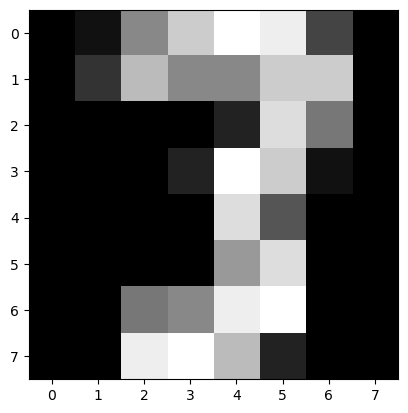

In [4]:
import numpy as np
import matplotlib . pyplot as plt
is_3 = target == 3
img = data[is_3][2].reshape(8, 8) # Reshape the data to 8x8 image
assert 2 == len(img.shape)
plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest") # also try interpolation="bicubic"
plt.show()

In [109]:
from sklearn import model_selection

# Filter dataset to only include digits 3 and 9
is_3_or_9 = np.logical_or(target == 3, target == 9)
data_3_or_9 = data[is_3_or_9]
target_3_or_9 = target[is_3_or_9]

X_all = data_3_or_9
y_all = target_3_or_9
X_train , X_test , y_train , y_test =\
model_selection.train_test_split (X_all, y_all,
test_size = 0.4, random_state = 0)

# 2 Handcrafted Classifier

In [110]:
# Calculate mean
mean_3 = np.mean(data_3_or_9[target_3_or_9 == 3], axis=0)
mean_9 = np.mean(data_3_or_9[target_3_or_9 == 9], axis=0)
pixel_diffs = np.abs(mean_3 - mean_9)
k = 5
top_k_indices = np.argsort(pixel_diffs)[::-1][:k]
for i, idx in enumerate(top_k_indices):
    print(f"Pixel {i+1}: Index {idx}, Difference {pixel_diffs[idx]}")

Pixel 1: Index 26, Difference 8.957650273224044
Pixel 2: Index 18, Difference 8.795081967213115
Pixel 3: Index 29, Difference 8.454553734061932
Pixel 4: Index 36, Difference 6.954735883424408
Pixel 5: Index 21, Difference 4.788706739526411


In [111]:
def features2d(X):
    # Define indices of two pixels that seem to distinguish between 3's and 9's
    pixel1_idx = 26
    pixel2_idx = 18
    pixel1 = X[:, pixel1_idx]
    pixel2 = X[:, pixel2_idx]
    
    # Construct 2-dimensional feature space using a linear combination of the two pixels
    features = np.stack([pixel1, pixel2], axis=1)
    
    return features

In [8]:
print(features2d(X_train))

[[11. 16.]
 [16. 10.]
 [ 4. 10.]
 ...
 [ 1.  7.]
 [ 3.  2.]
 [11. 11.]]


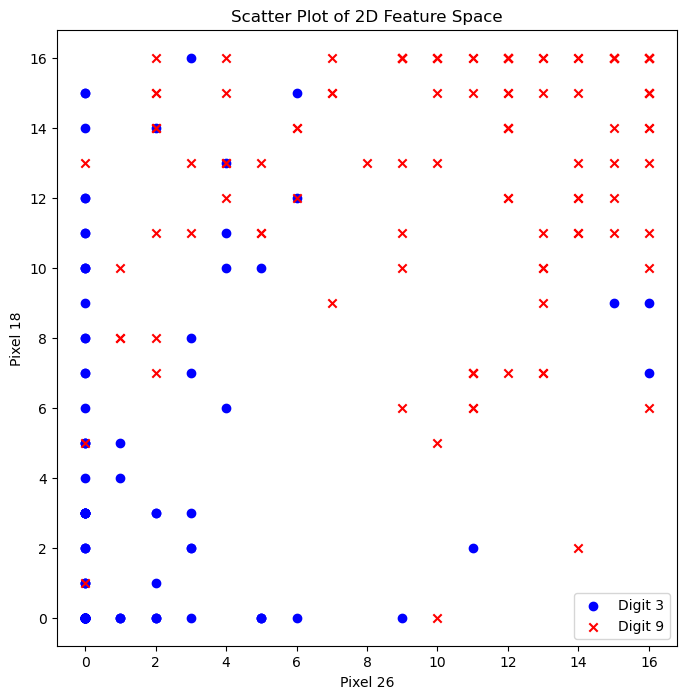

In [112]:
# Extract 2D features from training set
X_train_2d = features2d(X_train)

# Create scatter plot of 2D feature space
plt.figure(figsize=(8, 8))
plt.scatter(X_train_2d[y_train == 3, 0], X_train_2d[y_train == 3, 1], c='b', marker='o', label='Digit 3')
plt.scatter(X_train_2d[y_train == 9, 0], X_train_2d[y_train == 9, 1], c='r', marker='x', label='Digit 9')
plt.title('Scatter Plot of 2D Feature Space')
plt.xlabel('Pixel 26')
plt.ylabel('Pixel 18')
plt.legend()
plt.show()

In [113]:
from sklearn.metrics import accuracy_score

def nearest_mean(training_features, training_labels, test_features):
    mean_3 = np.mean(training_features[training_labels == -1], axis=0)
    mean_9 = np.mean(training_features[training_labels == 1], axis=0)

    def dist(x, y):
        return np.sum((x - y) ** 2)

    predicted_labels = []
    for i in range(len(test_features)):
        dist_3 = dist(test_features[i], mean_3)
        dist_9 = dist(test_features[i], mean_9)
        if dist_3 < dist_9:
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)

    return np.array(predicted_labels)


y_train_new = np.where(y_train == 3, -1, 1) # Convert 3's to -1's and 9's to 1's
y_test_new = np.where(y_test == 3, -1, 1) # Convert 3's to -1's and 9's to 1's

# Compute training error
train_preds = nearest_mean(X_train_2d, y_train_new, X_train_2d)
train_acc = accuracy_score(y_train_new, train_preds)

# Compute test error
X_test_2d = features2d(X_test)
test_preds = nearest_mean(X_train_2d, y_train_new, X_test_2d)
test_acc = accuracy_score(y_test_new, test_preds)

print('Training error:', 1 - train_acc)
print('Test error:', 1 - test_acc)

Training error: 0.11059907834101379
Test error: 0.0821917808219178


# linear combination of features

error of test set: 0.1232876712328767
error of training set: 0.11981566820276497


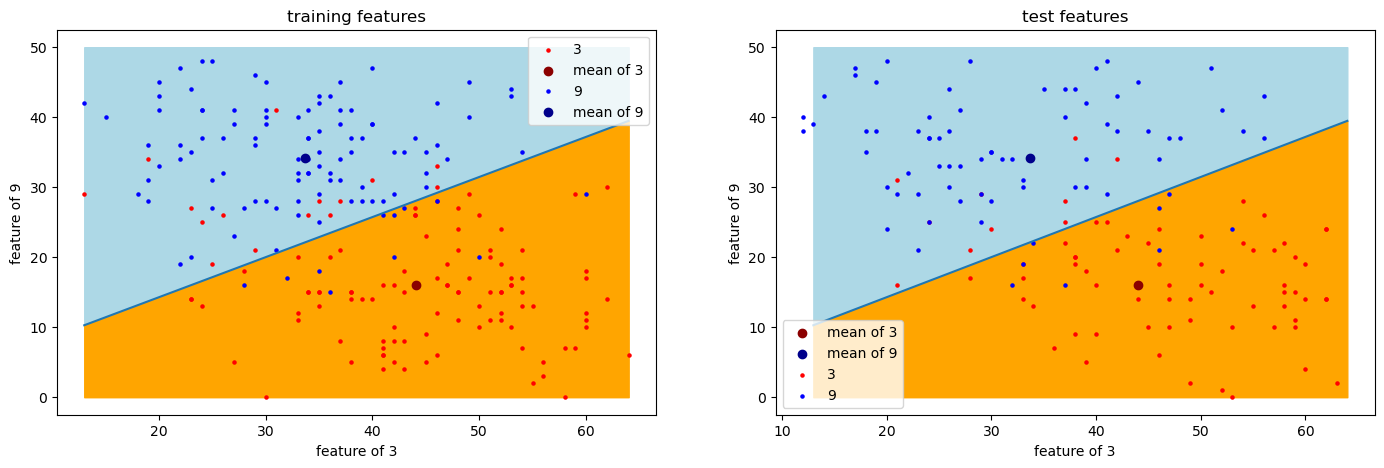

In [58]:
def determine_feature_mean(features):
    features_of_3 = []
    features_of_9 = []

    for i in range(len(y_train)):
        if(y_train[i] == 3):
            features_of_3.append(features[i])
        if(y_train[i] == 9):
            features_of_9.append(features[i])

    mean_of_3 = [np.mean(np.array(features_of_3)[:,0]), np.mean(np.array(features_of_3)[:,1])]
    mean_of_9 = [np.mean(np.array(features_of_9)[:,0]), np.mean(np.array(features_of_9)[:,1])]
    
    return mean_of_3, mean_of_9

def nearest_mean(training_features, training_labels, test_features):
    mean_of_3, mean_of_9 = determine_feature_mean(training_features)
    
    predicted_labels = []
    for i in range(len(test_features)):
        dist_to_3 = (test_features[i][0] - mean_of_3[0])**2 + (test_features[i][1] - mean_of_3[1])**2
        dist_to_9 = (test_features[i][0] - mean_of_9[0])**2 + (test_features[i][1] - mean_of_9[1])**2
        
        if(dist_to_3 < dist_to_9):
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)

    return predicted_labels

def calculate_error(predicted_labels, real_labels):    
    number_errors = 0
    for i in range(len(predicted_labels)):     
        real_label_modified = -1 if real_labels[i] == 3 else 1
        
        if(not predicted_labels[i] == real_label_modified):
            number_errors += 1
         
        #print(number_errors)
    return number_errors / len(predicted_labels)

def create_decision_line(features):
    mean_of_3, mean_of_9 = determine_feature_mean(features)
    
    def line(x, a, b):
        return a * x + b
    
    def inverse_line(y, a, b):
        return (y - b) / a
    
    x_min = min(np.array(features)[:,0])
    x_max = max(np.array(features)[:,0])
    y_min = min(np.array(features)[:,1])
    y_max = max(np.array(features)[:,1])
 
    slope = (mean_of_3[1] - mean_of_9[1]) / (mean_of_3[0] - mean_of_9[0])
    slope = -slope**-1
    y_intersect = 0.5 * (mean_of_9[1] + mean_of_3[1]) - slope * 0.5 * (mean_of_9[0] + mean_of_3[0])
    x = np.linspace(max(inverse_line(y_min, slope, y_intersect), x_min), min(inverse_line(y_max, slope, y_intersect), x_max), 10)

    return x, line(x, slope, y_intersect)

def do_all():
    
    def features2d(x):
        features = []
        for i in range(len(x)):
            feature_of_3_i = x[i][20] + x[i][28] + 2*x[i][58]# some function of pixels
            feature_of_9_i = x[i][26] + x[i][18] + x[i][37]

            features.append([feature_of_3_i, feature_of_9_i])
        return features
        
    

    training_features = features2d(X_train)
    test_features = features2d(X_test)
    features_of_3 = []
    features_of_9 = []

    for i in range(len(y_train)):
        if(y_train[i] == 3):
            features_of_3.append(training_features[i])
        if(y_train[i] == 9):
            features_of_9.append(training_features[i])

    mean_of_3, mean_of_9 = determine_feature_mean(training_features)
    
    predicted_test_labels = nearest_mean(training_features, y_train, test_features)
    predicted_training_labels = nearest_mean(training_features, y_train, training_features)
    
    print("error of test set: " + str(calculate_error(predicted_test_labels, y_test)))
    print("error of training set: " + str(calculate_error(predicted_training_labels, y_train)))
       
    plt.figure(figsize = (17,5))
    plt.subplot(121)
    x, y = create_decision_line(training_features)
    plt.plot(x, y)
    plt.fill_between(x,y,50, color = "lightblue")
    plt.fill_between(x,y, color = "orange")
    plt.scatter(np.array(features_of_3)[:,0], np.array(features_of_3)[:,1], color = "red", label = "3", s = 5)
    plt.scatter(mean_of_3[0], mean_of_3[1], color = "darkred", label = "mean of 3")
    plt.scatter(np.array(features_of_9)[:,0], np.array(features_of_9)[:,1], color = "blue", label = "9", s = 5)
    plt.scatter(mean_of_9[0], mean_of_9[1], color = "darkblue", label = "mean of 9")
    plt.title("training features")
    plt.xlabel("feature of 3")
    plt.ylabel("feature of 9")
    plt.legend()
    
    test_features_of_3 = []
    test_features_of_9 = []
    
    for i in range(len(y_test)):
        if(y_test[i] == 3):
            test_features_of_3.append(test_features[i])
        if(y_test[i] == 9):
            test_features_of_9.append(test_features[i])
    
    plt.subplot(122)
    plt.plot(x, y)
    plt.fill_between(x,y,50, color = "lightblue")
    plt.fill_between(x,y, color = "orange")
    plt.scatter(mean_of_3[0], mean_of_3[1], color = "darkred", label = "mean of 3")
    plt.scatter(mean_of_9[0], mean_of_9[1], color = "darkblue", label = "mean of 9")
    plt.scatter(np.array(test_features_of_3)[:,0], np.array(test_features_of_3)[:,1], color = "red", label = "3", s = 5)
    plt.scatter(np.array(test_features_of_9)[:,0], np.array(test_features_of_9)[:,1], color = "blue", label = "9", s = 5)
    plt.title("test features")
    plt.xlabel("feature of 3")
    plt.ylabel("feature of 9")
    plt.legend()
    plt.show()

    #preparation
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection

digits = load_digits()
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

indeces = [i for i, x in enumerate(target) if x == 3 or x == 9]
filtered_data = data[indeces]
filtered_images = images[indeces]
filtered_target = target[indeces]

X_train, X_test, y_train, y_test = model_selection.train_test_split(filtered_data, filtered_target, test_size = 0.4, random_state = 0)

do_all()

# 3 LDA

### 3.1 Implement LDA training

In [115]:
def fit_lda(training_features, training_labels):
    unique_labels = np.unique(training_labels)
    num_classes = len(unique_labels)
    num_features = training_features.shape[1]
    
    mu = np.zeros((num_classes, num_features))
    covmat = np.zeros((num_features, num_features))
    p = np.zeros(num_classes)
    
    for i, label in enumerate(unique_labels):
        # get all instances with the current label
        label_indices = np.where(training_labels == label)[0]
        num_instances = len(label_indices)
        p[i] = num_instances / len(training_labels)
        
        # compute class mean
        mu[i] = np.mean(training_features[label_indices], axis=0)
        
        # compute class covariance matrix
        covmat += np.cov(training_features[label_indices].T) * (num_instances - 1)
        
    # divide by the total number of instances to get the covariance matrix
    covmat /= len(training_labels)
    
    return mu, covmat, p

In [116]:
y_train_new = np.where(y_train == 3, -1, 1) # Convert 3's to -1's and 9's to 1's
y_test_new = np.where(y_test == 3, -1, 1) # Convert 3's to -1's and 9's to 1's

# Apply fit function to feature data from task 2
mu_2d, covmat_2d, p_2d = fit_lda(X_train_2d, y_train_new)
print(mu_2d)
print(covmat_2d)
print(p_2d)

[[ 1.45045045  3.5045045 ]
 [ 9.99056604 12.38679245]]
[[16.25100481  3.42470768]
 [ 3.42470768 17.84741593]]
[0.51152074 0.48847926]


In [117]:
# Apply fit function to full vector of 64 pixels
mu_full, covmat_full, p_full = fit_lda(X_train, y_train_new)
print(mu_full.shape)
print(covmat_full.shape)
print(p_full)

(2, 64)
(64, 64)
[0.51152074 0.48847926]


In [101]:
# filter out pixels that have a variance smaller than 0.001
variances = np.var(X_train, axis=0)
mask = variances >= 0.001
X_train_masked = X_train[:, mask]
X_test_masked = X_test[:,mask]

# Apply fit function to filterted vector
mu_masked, covmat_masked, p_masked = fit_lda(X_train_masked, y_train)

### 3.2 Implement LDA prediction

In [119]:
import numpy as np

def predict_lda(mu, covmat, p, test_features):

    covmat_inv = np.linalg.inv(covmat)
    beta = beta = np.dot(covmat_inv,(mu[1] - mu[0]).T)
    b = -0.5 * np.dot((mu[1] + mu[0]),beta) + np.log(p[0] / p[1])
    
    # calculate the discriminant function for each test instance
    discriminant = np.dot(test_features, beta) + b
    
    # assign the predicted label based on the maximum discriminant value
    predicted_labels = np.sign(discriminant)
    
    return predicted_labels

In [120]:
# call predict_lda() on the training and test data to obtain the predicted labels
train_predicted_labels = predict_lda(mu_masked, covmat_masked, p_masked, X_train_masked)
test_predicted_labels = predict_lda(mu_masked, covmat_masked, p_masked, X_test_masked)

# calculate the training and test error rates
train_error_rate = np.mean(train_predicted_labels != y_train_new)
test_error_rate = np.mean(test_predicted_labels != y_test_new)

print("Training error rate:", train_error_rate)
print("Test error rate:", test_error_rate)

Training error rate: 0.004608294930875576
Test error rate: 0.0136986301369863


### 3.3 Visualization

In [121]:
X_train_2d.shape

(217, 2)

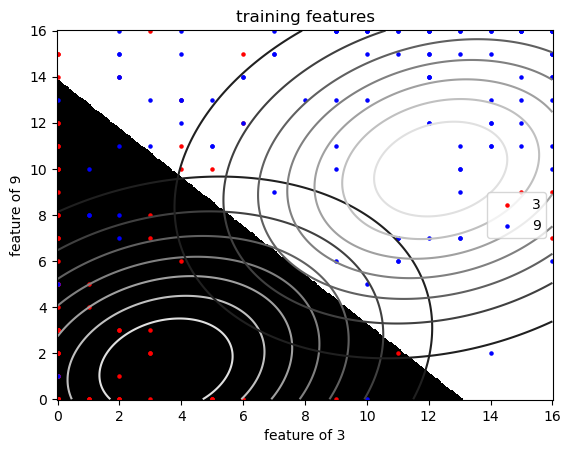

[13.53271285 20.56570789]
[[-0.78325883 -0.62169574]
 [ 0.62169574 -0.78325883]]


In [123]:
#with the feature function from 1.2
training_labels = y_train_new
mu, covmat, p = fit_lda(X_train_2d, training_labels)

predicted_train_labels = predict_lda(mu, covmat, p, X_train_2d)
predicted_test_labels = predict_lda(mu, covmat, p, X_train_2d)

beta = np.dot(np.linalg.inv(covmat), (mu[1] - mu[0]).T) 
b = -0.5 * (mu[1] + mu[0]).dot(beta) + np.log(p[0] / p[1])

training_features = np.array(X_train_2d)
x = np.linspace(min(training_features[:,0]), max(training_features[:,0]), 400)
y = np.linspace(min(training_features[:,1]), max(training_features[:,1]), 400)

def contour(x, y, mu):
    return 1 / np.sqrt(2*np.pi*np.linalg.det(covmat)) * np.exp(-0.5 * (np.array([x - mu[0], y - mu[1]]).dot(np.linalg.inv(covmat)).dot(np.array([x - mu[0], y - mu[1]]))))

z_contour_3 = np.array([np.zeros(len(x)) for i in range(len(y))])
z_contour_9 = np.array([np.zeros(len(x)) for i in range(len(y))])

for i in range(len(x)):
    for j in range(len(y)):
        z_contour_3[i][j] = contour(x[i], y[j], mu[0])
        z_contour_9[i][j] = contour(x[i], y[j], mu[1])

plt.contour(x, y, z_contour_3)
plt.contour(x, y, z_contour_9)

x, y = np.meshgrid(x, y)
z = np.sign(x * beta[0] + y * beta[1] + b)
plt.pcolormesh(x, y, z)
plt.scatter(training_features[y_train == 3, 0], training_features[y_train == 3, 1], color = "red", label = "3", s = 5)
plt.scatter(training_features[y_train == 9, 0], training_features[y_train == 9, 1], color = "blue", label = "9", s = 5)
plt.title("training features")
plt.xlabel("feature of 3")
plt.ylabel("feature of 9")
plt.legend()
plt.show()

eigenvalues, eigenvectors = np.linalg.eig(covmat)
print(eigenvalues)
print(eigenvectors)

In [ ]:
#with all pixels except dead pixels as features

mu, covmat, p = fit_lda(X_train_masked, training_labels)
test_predicted_labels = predict_lda(mu, covmat, p, X_test_masked)
train_predicted_labels = predict_lda(mu, covmat, p, X_train_masked)

# calculate the training and test error rates
train_error_rate = np.mean(train_predicted_labels != y_train_new)
test_error_rate = np.mean(test_predicted_labels != y_test_new)

print("Training error rate:", train_error_rate)
print("Test error rate:", test_error_rate)

# 4

In [26]:
import numpy as np

def fit_svm(training_features, training_labels, learning_rate=0.001, lambda_param=0.1, n_iters=500):
    '''Parameters
    -------------------
    training_features : numpy.ndarray, contains the training data. Each row is a sample, each column a feature
    training_labels : numpy.ndarray, contains the class-label of the training data.
    learning_rate : float, for the gradient decent (def 0.001)
    lambda_param : float, for the cost function for determining the weight vector.
    Greater lambda leads to higher margin of the hyperplane and vice versa. (def 0.1)
    n_iters : int, number of iterations (def 500)
    -------------------
    Return
    -------------------
    Returns w and b, the weight vector and the bias respectively.
    -------------------
    Trains the SVM by finding the optimal values for w and b using gradient decent.
    '''

    label_ = np.where(training_labels <= 0, -1, 1)  # we want the classes to be labeled either 1 or -1
    n_sample, n_features = training_features.shape  # No. of rows = sample size, No. of columns = feature size

    w = np.zeros(n_features)
    b = 0

    for _ in range(n_iters):
        for idx, x_i in enumerate(training_features):
            condition = label_[idx] * (np.dot(x_i, w) - b) >= 1  # the derivative of the cost function
            # depends on this condition
            if condition:
                w -= learning_rate * (2 * lambda_param * w)
            else:
                w -= learning_rate * (2 * lambda_param * w - np.dot(x_i, label_[idx]))
                b -= learning_rate * label_[idx]

    return w, b

def predict_svm(X, w, b):
    '''Parameters
    -------------------
    X : numpy.ndarray, contains the data of the samples for the prediction.
    Each row is a sample, each column a feature.
    w : numpy.ndarray, the weight vector.
    b : float, the bias.
    -------------------
    Return
    -------------------
    Returns a numpy.ndarray containing the labels from the prediction.
    '''
    linear_output = np.dot(X, w) - b
    return np.sign(linear_output)


[0.05636221 0.03786291] -0.6621399999996214


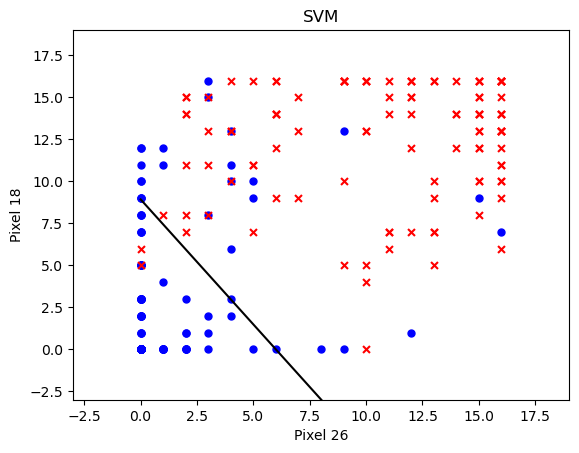

In [43]:
def get_hyperplane_value(x, w, b, offset):   # auxiliary function for visualizing the results
    return (-w[0] * x + b + offset) / w[1]

w, b = fit_svm(X_train_2d, y_train_new, learning_rate=0.00001, lambda_param=0.01, n_iters=1500)
print(w,b)

fig = plt.figure()
aux = fig.add_subplot(1, 1, 1)
plt.scatter(X_train_2d[y_train == 3, 0], X_train_2d[y_train == 3, 1], c='b', marker='o', label='Digit 3', s=25)
plt.scatter(X_train_2d[y_train == 9, 0], X_train_2d[y_train == 9, 1], c='r', marker='x', label='Digit 9', s=25)
plt.xlabel('Pixel 26')
plt.ylabel('Pixel 18')
#plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_new, s=25)
plt.title('SVM')

x0_1 = np.amin(X_train_2d[:, 0])
x0_2 = np.amax(X_train_2d[:, 0])

x1_1 = get_hyperplane_value(x0_1, w, b, 0)
x1_2 = get_hyperplane_value(x0_2, w, b, 0)

x1_1_a = get_hyperplane_value(x0_1, w, b, -1)
x1_2_a = get_hyperplane_value(x0_2, w, b, -1)

x1_1_b = get_hyperplane_value(x0_1, w, b, 1)
x1_2_b = get_hyperplane_value(x0_2, w, b, 1)

aux.plot([x0_1, x0_2], [x1_1, x1_2], 'y--')
aux.plot([x0_1, x0_2], [x1_1_a, x1_2_a], 'k')
aux.plot([x0_1, x0_2], [x1_1_b, x1_2_b], 'k')

x1_min = np.amin(X_train_2d[:, 1])
x1_max = np.amax(X_train_2d[:, 1])
aux.set_ylim([x1_min - 3, x1_max + 3])
aux.set_xlim([x0_1 - 3, x0_2 + 3])

plt.show()

Since it is not possible to see how many blue dots and red x are in one spot its is hard to judge the hyperplane. however it is minimizing the red x to be on the "blue dots" side of the hyperplane.

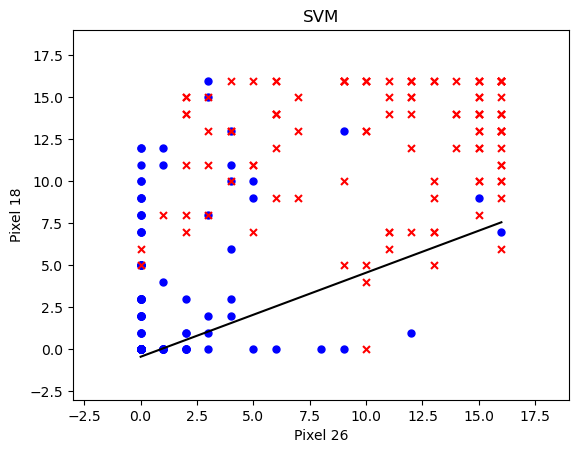

In [44]:
from sklearn.svm import SVC

# train an SVM on the training data
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_2d, y_train_new)

# extract the hyperplane parameters
w = svm.coef_[0]
b = svm.intercept_[0]

fig = plt.figure()
aux = fig.add_subplot(1, 1, 1)
plt.scatter(X_train_2d[y_train == 3, 0], X_train_2d[y_train == 3, 1], c='b', marker='o', label='Digit 3', s=25)
plt.scatter(X_train_2d[y_train == 9, 0], X_train_2d[y_train == 9, 1], c='r', marker='x', label='Digit 9', s=25)
plt.xlabel('Pixel 26')
plt.ylabel('Pixel 18')
#plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_new, s=25)
plt.title('SVM')

x0_1 = np.amin(X_train_2d[:, 0])
x0_2 = np.amax(X_train_2d[:, 0])

x1_1 = get_hyperplane_value(x0_1, w, b, 0)
x1_2 = get_hyperplane_value(x0_2, w, b, 0)

x1_1_a = get_hyperplane_value(x0_1, w, b, -1)
x1_2_a = get_hyperplane_value(x0_2, w, b, -1)

x1_1_b = get_hyperplane_value(x0_1, w, b, 1)
x1_2_b = get_hyperplane_value(x0_2, w, b, 1)

aux.plot([x0_1, x0_2], [x1_1, x1_2], 'y--')
aux.plot([x0_1, x0_2], [x1_1_a, x1_2_a], 'k')
aux.plot([x0_1, x0_2], [x1_1_b, x1_2_b], 'k')

x1_min = np.amin(X_train_2d[:, 1])
x1_max = np.amax(X_train_2d[:, 1])
aux.set_ylim([x1_min - 3, x1_max + 3])
aux.set_xlim([x0_1 - 3, x0_2 + 3])

plt.show()

The sklearn classifier does not seem to find a good hyperplane. However it is not finetuned and we can not see how many dots or x are in one spot.

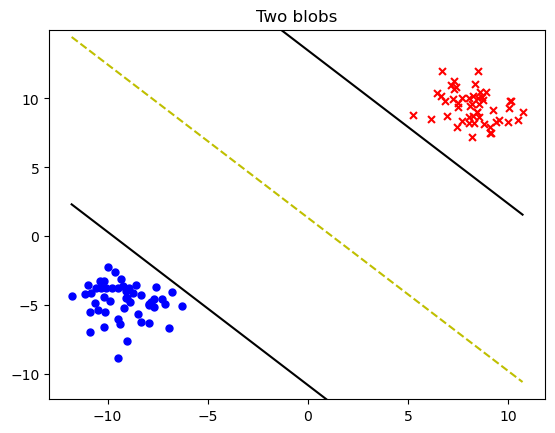

In [55]:
from sklearn.datasets import make_blobs


X, labels = make_blobs(n_features=2, centers=2, cluster_std=1.25, random_state=234)
labels = np.where(labels == 0, -1, 1)

w, b = fit_svm(X, labels)

fig = plt.figure()
aux = fig.add_subplot(1, 1, 1)

plt.scatter(X[labels == -1, 0], X[labels == -1, 1], c='b', marker='o', label='Blob A', s=25)
plt.scatter(X[labels == 1, 0], X[labels == 1, 1], c='r', marker='x', label='Blob B', s=25)
plt.title('Two blobs')

x0_1 = np.amin(X[:, 0])
x0_2 = np.amax(X[:, 0])

x1_1 = get_hyperplane_value(x0_1, w, b, 0)
x1_2 = get_hyperplane_value(x0_2, w, b, 0)

x1_1_a = get_hyperplane_value(x0_1, w, b, -1)
x1_2_a = get_hyperplane_value(x0_2, w, b, -1)

x1_1_b = get_hyperplane_value(x0_1, w, b, 1)
x1_2_b = get_hyperplane_value(x0_2, w, b, 1)

aux.plot([x0_1, x0_2], [x1_1, x1_2], 'y--')
aux.plot([x0_1, x0_2], [x1_1_a, x1_2_a], 'k')
aux.plot([x0_1, x0_2], [x1_1_b, x1_2_b], 'k')

x1_min = np.amin(X[:, 1])
x1_max = np.amax(X[:, 1])
aux.set_ylim([x1_min - 3, x1_max + 3])

plt.show()


I was curious as to whether my code actually works, which is why I decided to test it on this simple example and it seems to plot and work correctly.